# Introduction

Here we are finalising the information that we would like to gather from the molecules db. Specifically, we would want tabled information for each ingredient, containing the proportions of molecules for each ingredient.

# Overview

Getting this finalised dataset entails:

- Selecting from duplicate content entries (selecting orig_foods)
- Averaging from duplicate content entries
- Aggregating final dataset

# Setup

In [1]:
#|default_exp molecule.finalise

In [2]:
#| export
from pyprojroot import here
root = here()
import sys
sys.path.append(str(root))

In [3]:
#| export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json

from food_database.molecule.match import *
from food_database.density.food_match import *

from functools import reduce

import pickle

In [4]:
#| export
pd.options.mode.chained_assignment = None  # default='warn'

In [5]:
ingredients_df = pd.read_feather('../data/local/recipe/partial/ingredients/0.feather')
expanded_ingredients_df = pd.read_feather('../data/local/recipe/partial/expanded_ingredients/0.feather')
food_df = pd.read_feather('../data/local/molecule/full/food/1_processed.feather')
content_df = pd.read_feather('../data/local/molecule/full/content/1_processed.feather')
compound_df = pd.read_feather('../data/local/molecule/full/compound/1_processed.feather')
food_ids = pd.read_feather('../data/local/molecule/partial/food_ids/1_na_filled.feather')

# Averaging Duplicate Content Values

Here we have entries of each compound measurement - measured in a standardised concentration of mg/100g. What we want to form is a table of the foods, with features for the concentration of each chemical compound. 

### Handling NA's

#### Content DF

The NA measuremnets coming from this dataset we have already established as seen compounds, but without having thier concentrations measured. How do we deal with this numerically?

Since they are registered as being seen, we should have a (>0) value for them. What makes the most sense is to use the total mean of this value.

#### Expanded DF

Since the data here comes from various sources, there is not a standardised set of measured compounds, so not all foods will have the full featureset. These NA's can be filled as 0, as there was no study which registered them as being present.

In [30]:
content_df['concentration'].notnull().sum() / content_df.index.get_level_values(1).nunique()

9.853602148709754

In [31]:
mean_source_concentrations = content_df.groupby('source_id').apply(lambda item: item['concentration'].mean(skipna=True))
mean_source_concentrations

source_id
4            0.38438
13          1.223154
14        535.347763
24          0.113715
25          0.902589
             ...    
139984          <NA>
139985          <NA>
139986          <NA>
139987          <NA>
139988          <NA>
Length: 58826, dtype: object

Filtering compounds without any measured values.

In [32]:
content_df = content_df.loc[~content_df.index.get_level_values(1).isin(mean_source_concentrations.index[mean_source_concentrations.isna()])]

In [33]:
mean_source_concentrations = content_df.groupby('source_id').apply(lambda item: item['concentration'].mean(skipna=True))
assert mean_source_concentrations.isna().sum() == 0

In [34]:
content_df = content_df.reset_index(0)
content_df['concentration'] = content_df['concentration'].fillna(mean_source_concentrations)
content_df = content_df.reset_index().set_index(['food_id', 'source_id'])

## Formatting

In [36]:
food_compounds_df = pd.pivot_table(content_df, index='food_id', columns='source_id', values='concentration', aggfunc='mean', fill_value=pd.NA)
food_compounds_df

source_id,4,13,14,24,25,27,31,35,40,41,...,125217,125218,125219,125220,125221,125222,125223,125225,125226,125227
food_id,,,,,,,,,,,,,,,,,,,,,
1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
5,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
6,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
7,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1023,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1024,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


## Filtering Nulls

### Rows

In [38]:
notna = food_compounds_df.notna().sum(axis=1)
notna

food_id
1       333
4       449
5       428
6       337
7       363
       ... 
1022     98
1023    183
1024    141
1025      1
1026      2
Length: 814, dtype: int64

Removing foods with low compound measurements.

In [39]:
notna = food_compounds_df.notna().sum(axis=1)
notna

food_id
1       333
4       449
5       428
6       337
7       363
       ... 
1022     98
1023    183
1024    141
1025      1
1026      2
Length: 814, dtype: int64

In [40]:
notna.mean(), notna.std()

(226.42997542997543, 154.2680272831017)

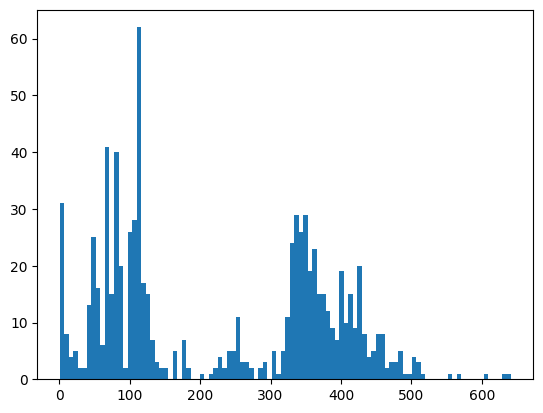

In [41]:
plt.hist(notna, bins=100);

There are still many foods with near 0 compound information. Which foods are they?

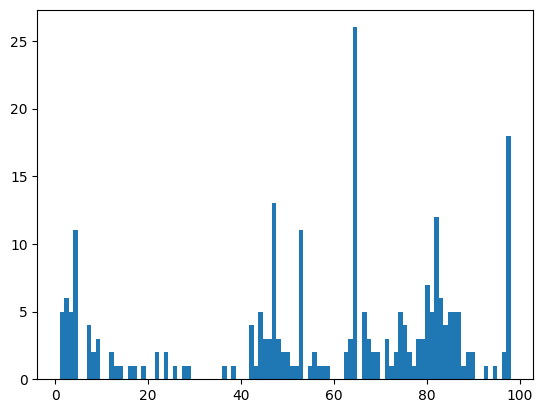

In [42]:
plt.hist(notna[notna<100], bins=100);

In [43]:
notna[notna < 10].to_frame('contents_count').join(food_df['name'])['name']

food_id
303                 bison
305      alaska blackfish
310             wild boar
316               buffalo
340        nuttall cockle
364                   elk
365                   emu
373         greylag goose
378            guinea hen
383                 horse
400        leather chiton
428              tunicate
435           velvet duck
438              pheasant
474          sea cucumber
491                 squab
529        pacific salmon
627            berry wine
708          cocoa liquor
892            crustacean
902              beverage
942            macroalgae
944           linseed oil
945          rapeseed oil
946           soybean oil
951              egg yolk
952             rosé wine
954            canola oil
955          dessert wine
956         red champagne
958       white champagne
959       red grape juice
960     white grape juice
986     whole wheat bread
1025          baking soda
1026        baking powder
Name: name, dtype: object

It's good to see these are simply just obscure ingredients, which can quite easily be removed.

In [44]:
food_compounds_df = food_compounds_df[(notna > 10) | food_compounds_df.index.isin([1025, 1026])]
food_compounds_df.shape

(780, 1746)

### Columns

Removing compounds with low total appearances.

In [45]:
notna_cols = food_compounds_df.notna().sum(axis=0)
notna_cols

source_id
4         2
13        1
14        4
24        2
25        2
         ..
125222    2
125223    2
125225    2
125226    2
125227    3
Length: 1746, dtype: int64

In [46]:
notna_cols.index[notna_cols<10].shape

(1005,)

In [47]:
food_compounds_df = food_compounds_df.loc[:, (notna_cols>10)]
food_compounds_df.shape

(780, 715)

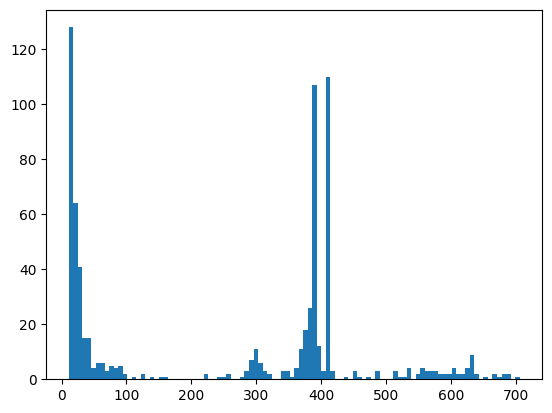

In [48]:
plt.hist((food_compounds_df.notna()).sum(axis=0), bins=100);

In [49]:
food_compounds_df = food_compounds_df.fillna(0)

In [54]:
assert (food_compounds_df > 1e3/1e-2).sum().sum() == 0 

## Converting

These above are using the weight concentration ratio measured in mg/100g.

In [64]:
ingredients_df.drop(['food_id'], axis=1, inplace=True)

# Testing

In [72]:
ingredients_df.join(food_ids)[['food_id']].join(food_compounds_df, on=['food_id'])

food_id  108        136       236  237  247  248  249  \
recipe  ingredient                                                          
1746116 0             667.0  0.0        0.0       0.0  0.0  0.0  0.0  0.0   
        1             670.0  0.0        0.0       0.0  0.0  0.0  0.0  0.0   
        2             633.0  0.0        0.0       0.0  0.0  0.0  0.0  0.0   
        3             195.0  0.0        0.0  0.109333  0.0  0.0  0.0  0.0   
        4             825.0  0.0  18.908334       0.0  0.0  0.0  0.0  0.0   
...                     ...  ...        ...       ...  ...  ...  ...  ...   
931097  9             994.0  0.0        0.0  0.109333  0.0  0.0  0.0  0.0   
        10             40.0  0.0        0.0  0.109333  0.0  0.0  0.0  0.0   
        11            125.0  0.0  18.908334  0.109333  0.0  0.0  0.0  0.0   
        12            334.0  0.0        0.0       0.0  0.0  0.0  0.0  0.0   
        13            119.0  0.0        0.0  0.109333  0.0  0.0  0.0  0.0   

                      307   312  ...    122183    122207    122257    122370  \
recipe  ingredient               ...                                           
1746116 0             0.0   0.0  ...       0.0       0.0       0.0       0.0   
        1             0.0   0.0  ...       0.0       0.0       0.0       0.0   
        2             0.0   0.0  ...       0.0       0.0       0.0       0.0   
        3             0.0   0.0  ...  23.49215  9.498727  2.253628  9.376545   
        4           100.0  10.0  ...  23.49215  9.498727  2.253628  9.376545   
...                   ...   ...  ...       ...       ...       ...       ...   
931097  9             0.0   0.0  ...  23.49215  9.498727  2.253628  9.376545   
        10            0.0   0.0  ...  23.49215  9.498727  2.253628  9.376545   
        11          100.0  10.0  ...  23.49215  9.498727  2.253628  9.376545   
        12            0.0   0.0  ...       0.0       0.0       0.0       0.0   
        13            0.0   0.0  ...  23.49215  9.498727  2.253628  9.376545   

                      122486     122510    123210    125087  125196    125197  
recipe  ingredient                                                             
1746116 0                0.0        0.0       0.0       0.0     0.0       0.0  
        1                0.0        0.0       0.0       0.0     0.0       0.0  
        2                0.0        0.0       0.0       0.0     0.0       0.0  
        3           9.376545  24.419212  0.023016       0.0     0.0       0.0  
        4           9.376545  24.419212  0.023016       0.0     0.0       0.0  
...                      ...        ...       ...       ...     ...       ...  
931097  9           9.376545  24.419212  0.023016       0.0     0.0       0.0  
        10          9.376545  24.419212  0.023016  3.954163     0.0  1.223189  
        11          9.376545  24.419212  0.023016       0.0     0.0       0.0  
        12               0.0        0.0       0.0       0.0     0.0       0.0  
        13          9.376545  24.419212  0.023016  3.954163     0.0       0.0  

[2450 rows x 716 columns]

# Saving

In [56]:
food_compounds_df

source_id,108,136,236,237,247,248,249,307,312,313,...,122183,122207,122257,122370,122486,122510,123210,125087,125196,125197
food_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.109333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016,0.0,0.0,0.0
4,0.0,0.0,0.109333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016,0.0,0.0,1.223189
5,0.0,0.0,0.109333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016,0.0,0.0,0.0
6,0.0,0.0,0.109333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016,0.0,0.0,0.0
7,0.0,0.0,0.109333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016,0.0,0.0,1.223189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016,0.0,0.0,0.0
1024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.49215,9.498727,2.253628,9.376545,9.376545,24.419212,0.023016,0.0,0.0,0.0


In [58]:
food_compounds_df.to_feather('../data/local/molecule/full/food_compounds/0.feather')
food_compounds_df.shape

(780, 715)